## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\gg\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[128,64,32]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
factor = [0.1,0.3,0.5,0.7,0.9]

In [14]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

results = {}
for i in range(0,len(factor)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (factor[i]))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.adam()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    reduce_lr = ReduceLROnPlateau(factor=factor[i], 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr])
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(factor[i])
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 32)                2080      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)

Epoch 47/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.8509 - acc: 0.7072 - val_loss: 1.4847 - val_acc: 0.5019 1s - loss: 0.8442 - acc: 0. - ETA: 1s - loss: 0.8
Epoch 48/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.8519 - acc: 0.7061 - val_loss: 1.4847 - val_acc: 0.5024

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 49/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.8520 - acc: 0.7065 - val_loss: 1.4847 - val_acc: 0.5019
Epoch 50/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.8513 - acc: 0.7070 - val_loss: 1.4847 - val_acc: 0.5019
Experiment with Regulizer = 0.300000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 

50000/50000 [==============================] - 5s 104us/step - loss: 0.8738 - acc: 0.6969 - val_loss: 1.4940 - val_acc: 0.5016
Epoch 43/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.8748 - acc: 0.6964 - val_loss: 1.4941 - val_acc: 0.5016
Epoch 44/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.8747 - acc: 0.6972 - val_loss: 1.4941 - val_acc: 0.5008
Epoch 45/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.8748 - acc: 0.6970 - val_loss: 1.4947 - val_acc: 0.5010
Epoch 46/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.8737 - acc: 0.6974 - val_loss: 1.4950 - val_acc: 0.5014

Epoch 00046: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
Epoch 47/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.8742 - acc: 0.6957 - val_loss: 1.4951 - val_acc: 0.5019
Epoch 48/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.8741 - acc: 0.6977 


Epoch 00037: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 38/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.8862 - acc: 0.6955 - val_loss: 1.5174 - val_acc: 0.4930
Epoch 39/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.8828 - acc: 0.6968 - val_loss: 1.5169 - val_acc: 0.4953
Epoch 40/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.8828 - acc: 0.6956 - val_loss: 1.5279 - val_acc: 0.4955
Epoch 41/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.8810 - acc: 0.6974 - val_loss: 1.5280 - val_acc: 0.4935
Epoch 42/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.8802 - acc: 0.6964 - val_loss: 1.5295 - val_acc: 0.4962

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 43/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.8776 - acc: 0.6977 - val_loss: 1.5243 - val_acc: 0.4949
Epoch 44/

50000/50000 [==============================] - 5s 98us/step - loss: 0.8906 - acc: 0.6887 - val_loss: 1.5470 - val_acc: 0.4863

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
Epoch 34/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.8630 - acc: 0.6996 - val_loss: 1.5746 - val_acc: 0.4877
Epoch 35/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.8539 - acc: 0.7017 - val_loss: 1.5935 - val_acc: 0.4850
Epoch 36/50
50000/50000 [==============================] - 6s 111us/step - loss: 0.8486 - acc: 0.7044 - val_loss: 1.6593 - val_acc: 0.4776
Epoch 37/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.8393 - acc: 0.7077 - val_loss: 1.5996 - val_acc: 0.4884
Epoch 38/50
50000/50000 [==============================] - 6s 111us/step - loss: 0.8315 - acc: 0.7097 - val_loss: 1.6291 - val_acc: 0.4794

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.00016806999628897755.
Epoch 39/50
50000

50000/50000 [==============================] - 6s 117us/step - loss: 0.9769 - acc: 0.6557 - val_loss: 1.6139 - val_acc: 0.4611
Epoch 28/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.9641 - acc: 0.6581 - val_loss: 1.7623 - val_acc: 0.4262cc: 0.
Epoch 29/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.9596 - acc: 0.6575 - val_loss: 1.6446 - val_acc: 0.4455

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 30/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.9389 - acc: 0.6676 - val_loss: 1.6973 - val_acc: 0.4450
Epoch 31/50
50000/50000 [==============================] - 6s 114us/step - loss: 0.9244 - acc: 0.6739 - val_loss: 1.5842 - val_acc: 0.4759
Epoch 32/50
50000/50000 [==============================] - 5s 107us/step - loss: 0.9145 - acc: 0.6760 - val_loss: 1.7664 - val_acc: 0.4478
Epoch 33/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.9052 - a

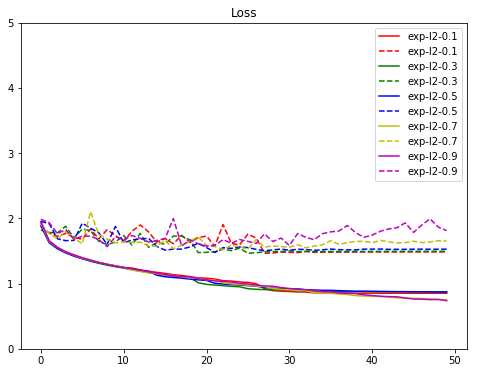

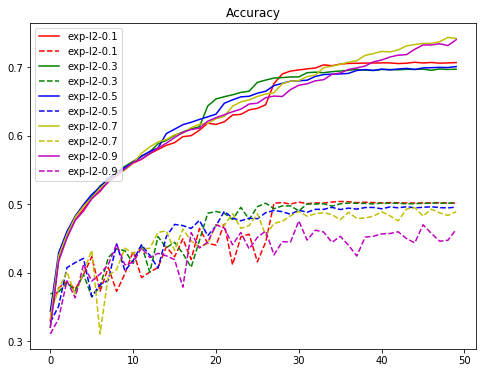

In [17]:
import matplotlib.pyplot as plt
# 繪製結果
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()